In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({
    'font.size': 15,
    'font.family': 'Arial',
    'axes.labelsize': 20,
    'axes.labelpad': 10,
    'axes.titlesize': 20,
    'axes.titlepad': 10
})
import seaborn as sns
import tqdm
import scipy.stats as stats

In [2]:
import torch
import numpy as np
import torch.distributions as dist

In [3]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 500, 10., [-5, 5])

In [4]:
X = torch.from_numpy(x_train).float()
X = torch.stack([torch.ones(len(X)), X, X**2, X**3]).T
y = torch.from_numpy(y_train).float()

In [5]:
def softplus(x):
    return torch.log(1 + torch.exp(x))
    # return torch.exp(x)

def jacobian(x):
    return torch.exp(x) / (1 + torch.exp(x))
     # return torch.exp(x)

def elbo(X, y, n_sample, a0=1, b0=1, beta=0.01):
    q_alpha = dist.Normal(a_mu, softplus(a_sigma))
    alpha = q_alpha.rsample([n_sample])
    
    S = L.mm(L.T)
    q_w = dist.MultivariateNormal(mu, S)
    w = q_w.rsample([n_sample])
    
    log_qz = q_alpha.log_prob(alpha).mean() + q_w.log_prob(w).mean()
    
    log_pxz = 0
    for i in range(n_sample):
        p_alpha = dist.Gamma(a0, b0)
        alpha_T = softplus(alpha[i])
        p_w = dist.MultivariateNormal(torch.zeros(4), 1/alpha_T*torch.eye(4))
        p_y = dist.Normal(0, 1/beta)
        diff = y - torch.matmul(w[i], X.T).squeeze()
        log_pxz += p_alpha.log_prob(alpha_T) + torch.log(jacobian(alpha[i])) + \
            p_w.log_prob(w[i]) + p_y.log_prob(diff).sum()
    log_pxz = log_pxz / n_sample
    elbo = log_pxz - log_qz
    return elbo

In [6]:
mu = torch.randn(4).requires_grad_()
L = torch.randn(4, 4).requires_grad_()
a_mu = torch.randn(1).requires_grad_()
a_sigma = torch.randn(1).requires_grad_()
optimizer = torch.optim.Adam([mu, L, a_mu, a_sigma], lr=0.1)

In [7]:
loss_list = []
for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    loss = -elbo(X, y, n_sample=10, beta=0.01)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 70.32it/s]


In [26]:
class VariationalLinearRegression:
    def __init__(self, beta=0.01, a0=1, b0=1, iters=100):
        self.beta = beta
        self.a0 = a0
        self.b0 = b0
        self.iters = iters
    
    def fit(self, X, y):
        XtX = torch.matmul(X.T, X)
        M = X.shape[1]
        self.a = self.a0 + M / 2
        self.b = self.b0
        for _ in range(self.iters):
            prev_b = self.b
            w_prec = self.beta * XtX
            w_prec[np.diag_indices(M)] += self.a / self.b
            self.w_var = w_prec.inverse()
            self.w_mean = self.beta * torch.matmul(self.w_var.mm(X.T), y)
            
            self.b = self.b0 + 0.5 * (self.w_mean ** 2).sum() + self.w_var.trace()
            
            if (prev_b - self.b).abs() < 1e-3:
                break
    
    def predict(self, X):
        y = torch.matmul(X, self.w_mean)
        y_var = 1 / self.beta + (torch.matmul(X, self.w_var) * X).sum(dim=1)
        y_std = torch.sqrt(y_var)
        return y, y_std

In [27]:
clf = VariationalLinearRegression(beta=0.01)
clf.fit(X, y)

In [63]:
clf.a, clf.b, clf.a/clf.b

(3.0, tensor(343.4276), tensor(0.0087))

In [54]:
with torch.no_grad():
    alpha_sample = softplus(dist.Normal(a_mu, softplus(a_sigma)).sample([2000]))

/Users/wangyulong/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


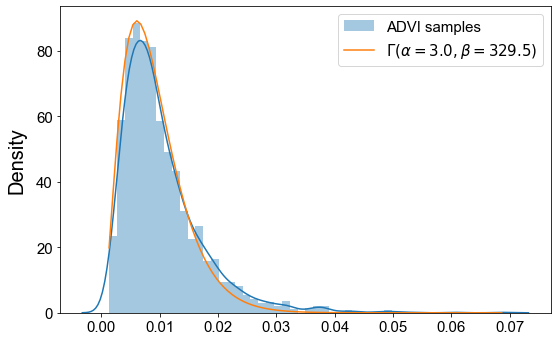

In [56]:
plt.figure(figsize=(8, 5))
sns.distplot(alpha_sample.squeeze(), label='ADVI samples')

G = stats.gamma(a=clf.a, scale=1/clf.b)
xrange = np.linspace(alpha_sample.min().item(), alpha_sample.max().item(), 100)
plt.plot(xrange, G.pdf(xrange), label=r"$\Gamma(\alpha=%.1f,\beta=%.1f)$" % (clf.a, clf.b))
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('advi-gamma-samples.png')